# **RIDGE Tuning**

In [16]:
import numpy as np
import pandas as pd
import datetime

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [17]:
def download_link(url):
  '''Method reformates the share link from Google Drive into fetchable form'''
  return 'https://drive.google.com/uc?id=' + url.split('/')[-2]

**Data preparation**

In [18]:
# Cycling data
cycling_data = pd.read_csv(download_link("https://drive.google.com/file/d/15eHai6zkPwOBMq59n8uIjjohuuiaV8DF/view?usp=sharing"))
cycling_data["DATUM_A_CAS"] = pd.to_datetime(cycling_data["DATUM_A_CAS"], errors="coerce")
cycling_data["DATUM_A_CAS"] = cycling_data["DATUM_A_CAS"].dt.date

In [25]:
cycling_data = cycling_data[["NAZOV", "SMER_DO", "SMER_Z", "DATUM_A_CAS", "POCET_DO", "POCET_Z"]]

aggregated_data = cycling_data.groupby(["NAZOV", "DATUM_A_CAS"], as_index=False).sum(numeric_only=True)
aggregated_data = aggregated_data[aggregated_data["DATUM_A_CAS"] >= datetime.date(2022, 1, 1)]

aggregated_data["POCET"] = aggregated_data["POCET_DO"] + aggregated_data["POCET_Z"]
aggregated_data = aggregated_data[["NAZOV", "DATUM_A_CAS", "POCET"]]

In [26]:
# Weather data
weather_data = pd.read_csv(download_link("https://drive.google.com/file/d/1keTewFIu3ceNYhfNuiLxD9vqlcW5t2S9/view?usp=sharing")).fillna(0)

# Average temperature, Min temperature, Max temperature, Precipitation, Snowing (rarely), Wind speed, Pressure
weather_data = weather_data[["date", "tavg", "tmin", "tmax", "prcp", "snow", "wspd", "pres"]]
weather_data["date"] = pd.to_datetime(weather_data["date"], errors="coerce")
weather_data["date"] = weather_data["date"].dt.date

**Train-Val-Test split**

We have decided to use year wise split of data, avoiding COVID-19 quarantine years before 2022. We perform split based on percentages, because not all data have the same length. In order to take into account data chronology, we use first <code>60 %</code> of data for training, second <code>30 %</code> for validation and remaining <code>10 %</code> for testing purposes.

In [27]:
# Getting all the routes available
routes = list(aggregated_data["NAZOV"].unique())

In [28]:
# Trying Starý most
x = ["tavg", "tmin", "tmax", "prcp", "snow", "wspd", "pres"]
y = ["POCET_DO", "POCET_Z"]

route_subsample = aggregated_data[aggregated_data["NAZOV"] == "#10 - Dunajská"]

DATA = pd.merge(left=route_subsample, right=weather_data, left_on="DATUM_A_CAS", right_on="date")

In [29]:
TRAIN = DATA[:int(0.6*len(DATA))]
VALIDATION = DATA[int(0.6*len(DATA)):int(0.9*len(DATA))]
TEST = DATA[int(0.9*len(DATA)):int(len(DATA))]

# RIDGE

In [31]:
maes = {}
for route in routes:
    row_mae = []
    for Alpha in np.arange(0.01, 10, 0.01):
        route_subsample = aggregated_data[aggregated_data["NAZOV"] == route]

        DATA = pd.merge(left=route_subsample, right=weather_data, left_on="DATUM_A_CAS", right_on="date")
        TRAIN = DATA[:int(0.6*len(DATA))]
        VALIDATION = DATA[int(0.6*len(DATA)):int(0.9*len(DATA))]
        TEST = DATA[int(0.9*len(DATA)):int(len(DATA))]
    
        MODEL = Ridge(alpha=Alpha)

        scaler_X = StandardScaler()

        # Fit & transform training data
        X_train = scaler_X.fit_transform(TRAIN[x])
        y_train = TRAIN[["POCET"]]

        # Train model
        MODEL.fit(X_train, y_train)

        # Transform validation data
        X_val = scaler_X.transform(VALIDATION[x])

        # Predict
        y_pred = MODEL.predict(X_val)

        # Evaluate
        mae = mean_absolute_error(VALIDATION["POCET"], y_pred)

        row_mae.append(100*mae/np.mean(DATA["POCET"]))
    maes[route] = row_mae.copy()

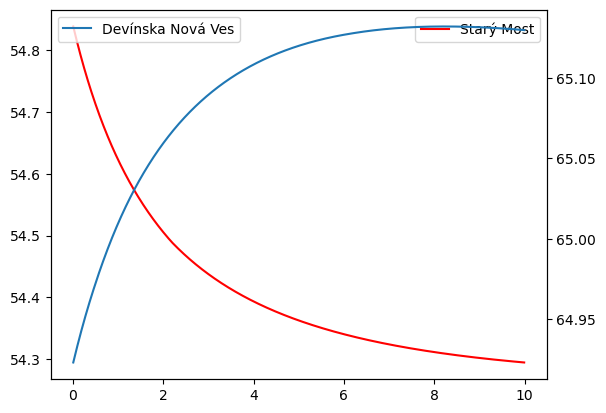

In [ ]:
plt.plot(np.arange(0.01, 10, 0.01), maes["#1 - Starý Most"], c="red")
plt.legend(["Starý Most"])
plt.twinx()
plt.plot(np.arange(0.01, 10, 0.01), maes["Devinska Nova Ves"])
plt.legend(["Devínska Nová Ves"])

In [ ]:
reference_alpha = np.arange(0.01, 10, 0.01)
best_settings = {}

for key in maes.keys():
    best_settings[key] = reference_alpha[np.argmin(maes[key])]

best_settings

{'#1 - Starý Most': np.float64(9.99),
 '#10 - Dunajská': np.float64(7.12),
 '#11 - Most Apollo': np.float64(0.01),
 '#12 - Železná studnička': np.float64(9.99),
 '#13 - Vajanského 1': np.float64(9.99),
 '#14 - Vajanského 2': np.float64(9.99),
 '#15 - Incheba Einsteinova': np.float64(1.11),
 '#16 - Trenčianska': np.float64(9.99),
 '#17 - Dunajská/Lazaretská': np.float64(0.01),
 '#2 - Starý most 2': np.float64(9.99),
 '#3 - River Park': np.float64(0.01),
 '#4 - Dolnozemská': np.float64(0.01),
 '#5 - Devínska cesta': np.float64(9.99),
 '#6 - Vajnorská': np.float64(0.01),
 '#7 - Vajnorská > NTC': np.float64(9.99),
 '#8 - Most SNP': np.float64(0.01),
 '#9 - Páričkova': np.float64(0.01),
 'Cyklomost Slobody': np.float64(9.99),
 'Devinska Nova Ves': np.float64(0.01),
 'Hradza Berg': np.float64(0.01),
 'Viedenska': np.float64(0.01)}